In [2]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
from controllers import DeePC
import gym
import mujoco_py
from gym import wrappers
from IPython import display

plt.rcParams["figure.figsize"] = (18,6)

%matplotlib inline
%reload_ext autoreload
%autoreload 

## Data Collection

In [3]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')

"""
    Timestep for InvertedPendelum-v4 is 0.02
"""

obs, info = env.reset()
ini = obs
Tini = 1
n = 4
N = 5
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 100
print(T)
render_collection = False

ud = []
yd = []
i = 0

while i < T:

    # restart loop if data is non-linear
    if np.abs(obs[1]) > 0.1 or np.abs(obs[0]) > 0.1 or np.abs(obs[2]) > 0.15 or np.abs(obs[3]) > 0.15 :
        obs, info = env.reset()
        i = 0
        ud = []
        yd = []

    # Add noise to action and roll sim forward
    action = [obs[1]*3 - np.random.randn()*0.01]
    obs, rew, done, info, _ = env.step(action)
    ud = np.append(ud,action)
    yd = np.append(yd,obs)

    # display gym annimation if requested
    if render_collection:
        plt.title(f"Action {action[0]:.2f} Theta {obs[1]:.2f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    i+=1

env.close()
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

120
yd shape : (480,)   ud shape : (120,)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_const = np.kron(np.ones(N), np.array([0.2, 0.2, 0.3, 0.3]))
u_const = np.ones(N)*3
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_const, u_constraints=u_const,
    N=N, Tini=Tini, n=n, T=T, p=p, m=m, Q=Q, R=R
)

120


In [5]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
rank = np.linalg.matrix_rank(H)
print(f'H has rank {rank} and shape {H.shape}')
if rank != H.shape[0]:
    raise ValueError

H has rank 10 and shape (10, 111)


In [6]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')


U = (6, 115), Up = (1, 115), Uf = (5, 115)
Y = (24, 115), Yp = (4, 115), Yf = (20, 115)


## Solver Setup

In [7]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)

PI = np.vstack([Up, Yp, Uf])
PI = np.linalg.pinv(PI)@PI
I = np.eye(PI.shape[0])
PI = I - PI

Q = np.diag([100,100,1,1])
Q_block = np.kron(np.eye(N), Q)
R = np.eye(N)*0.1 

# y_r = np.array([0.04,0,0,0]).reshape((p,))
y_r = np.zeros(p).reshape((p,))
A = np.vstack([Up,Yp,Uf,Yf])
A = np.linalg.pinv(A)
u_r = 0 # steady state control input
stacked_ref = np.hstack([
  np.kron(np.ones(Tini).reshape((Tini,)), u_r),
  np.kron(np.ones(Tini).reshape((Tini,)), y_r),
  np.kron(np.ones(N).reshape((N,)), u_r),
  np.kron(np.ones(N).reshape((N,)), y_r)
])
g_r = A @ stacked_ref

r = np.kron(np.ones(N).reshape((N,)), y_r)

cost = cp.quad_form(y, Q_block) + cp.quad_form(u,R) + cp.sum_squares(PI@(g))*10000 + cp.norm(g, 1)*1000

iter = 0
render_solution = False
y_const = np.kron(np.ones(N), np.array([0.2, 0.2, 0.3, 0.3]))
u_const = np.ones(N)*3

## Loop

In [8]:
u_ini = np.kron(np.ones(Tini), np.array([0]))
y_ini = np.kron(np.ones(Tini), np.array([0,0,0,0]))
# u_ini = ud[:m*Tini]
# y_ini = yd[:p*Tini]
yT = [*y_ini]
uT = [*u_ini]
print(f'u ini : {u_ini}\ny ini : {y_ini}')


env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
iter = 0

while iter < 100:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini, 
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= u_const,
    cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)
  action = prob.variables()[1].value[0]

  obs,_,done,_,_ = env.step([action])
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
  
  if render_solution:
    plt.title(f"Action {action:.2f}, X {obs[0]:.2f}, Theta {obs[1]:.2f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

u ini : [0.]
y ini : [0. 0. 0. 0.]


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
iter

89

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


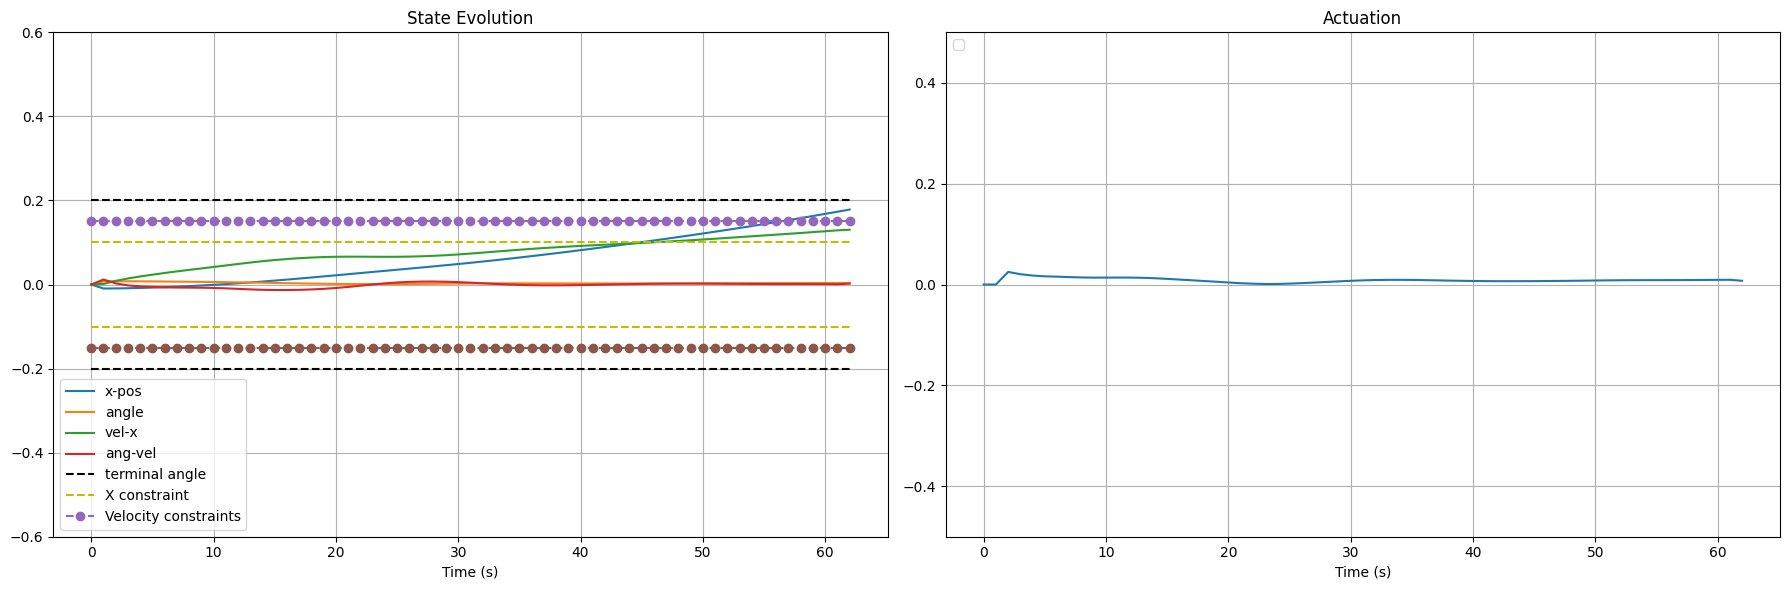

In [ ]:
T = len(uT)
yT = yT.reshape((T,p))
uT = uT.reshape((T,m))
plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.plot(range(0,T), np.ones(T)*0.1, 'y--', label='X constraint')
plt.plot(range(0,T), -np.ones(T)*0.1, 'y--')
plt.plot(range(0,T), np.ones(T)*0.15, 'o--', label='Velocity constraints')
plt.plot(range(0,T), -np.ones(T)*0.15, 'o--')
plt.legend(loc="lower left")
plt.ylim((-0.6,0.6))
plt.xlabel('Time (s)')
plt.title("State Evolution")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-0.5,0.5))
plt.grid('on')
plt.tight_layout()

plt.show()
yT = yT.reshape((T*p,))
